This notebook is to analyze parameters for specufex grouping of redpy clusters.

It so far includes:

    PCA - Principal Component Analysis
    Silhouette Score

Created 5/8/2023

Updated 5/16/2023

In [1]:
#imports
from sklearn.cluster import KMeans #for kmeans clustering
from sklearn.metrics import silhouette_samples, silhouette_score, mean_squared_error #for silhouette score
from sklearn import decomposition #for pca
# from sklearn import datasets 

import matplotlib.pyplot as plt #for plotting
import matplotlib.cm as cm #color maps for plotting
import numpy as np
import math #for ceil
import pandas as pd
import h5py #for reading/writing data
from obspy import Trace #for reading array as a trace

In [117]:
with h5py.File("/home/smocz/expand_redpy_new_files/h5/new_Rainier_template_waveforms.h5", "r") as f: #pull in fingerprints
    fingerprints = f["fingerprints"][()]
    template_name = f["template_name"][()]
#     group_id = f["group_id"][()]
    waveforms = f["waveforms"][()]
    print(f.keys()) #print what data is in this file

<KeysViewHDF5 ['fingerprints', 'template_name', 'waveforms']>


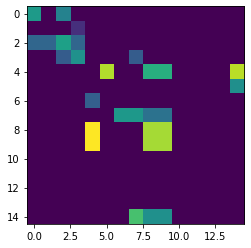

In [118]:
plt.imshow(fingerprints[13]) #show an example fingerprint

## PCA - Principal Component Analysis

Principal Component Analysis to reduce the dimensions of fingerprints

2 components -> 0.4476 variance ratio
5 components -> 0.652 variance ratio
10 components -> 0.77 variance ratio
15 components -> 0.8361 variance ratio
20 components -> 0.8736 variance ratio
25 components -> 0.9026 variance ratio
30 components -> 0.9263 variance ratio
35 components -> 0.9445 variance ratio
40 components -> 0.9592 variance ratio
45 components -> 0.9696 variance ratio
50 components -> 0.978 variance ratio
55 components -> 0.9846 variance ratio
60 components -> 0.989 variance ratio


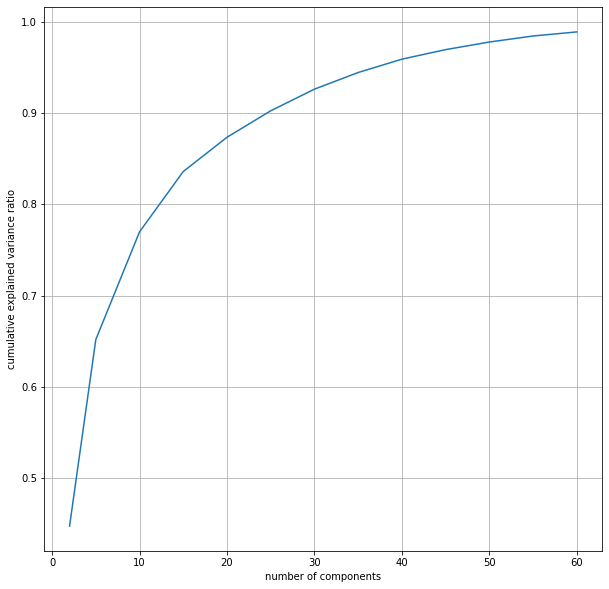

In [119]:
#determining ideal number of components for pca based on explained variance ratio (closer to 1 is better)
ncom_list = [2,5,10,15,20,25,30,35,40,45,50,55,60] #number of components to test

sum_list = [] #will be a list of cumulative explained variance ratio for each ncom
for ncom in ncom_list:
    X = fingerprints.reshape((fingerprints.shape[0], fingerprints.shape[1]**2))
    pca = decomposition.PCA(n_components=ncom) #get the pca function
    pca.fit(X) #use pca on data X
    
    vr = pca.explained_variance_ratio_
    sum_list.append(sum(vr))
    print(f'{ncom} components -> {round(sum(vr),4)} variance ratio')

# print('sum list',sum_list)

#plot
fig, ax = plt.subplots(1, figsize=(10,10)) #make plot

ax.plot(ncom_list, sum_list) #plot points, X[:,0] is the 0 of each datapoint in X
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance ratio')
plt.grid(True)

In [120]:
#number of components to use for pca
idealv = 0.86 #this is the value you want for variance

diff_list = [abs(i-idealv) for i in sum_list]
#look through ncom_list to find the ncom closest to idealv
ncom = ncom_list[diff_list.index( #find difference from idealv across ncom_list...
                min(diff_list))] #...get the minimum, find its index, pull from ncom_list
print('ncom =',ncom)

ncom = 20


shape of fingerprints (5331, 15, 15)
shape after reshape (5331, 225)
shape after pca (5331, 20)


Text(0.5, 1.0, 'Scatter after PCA')

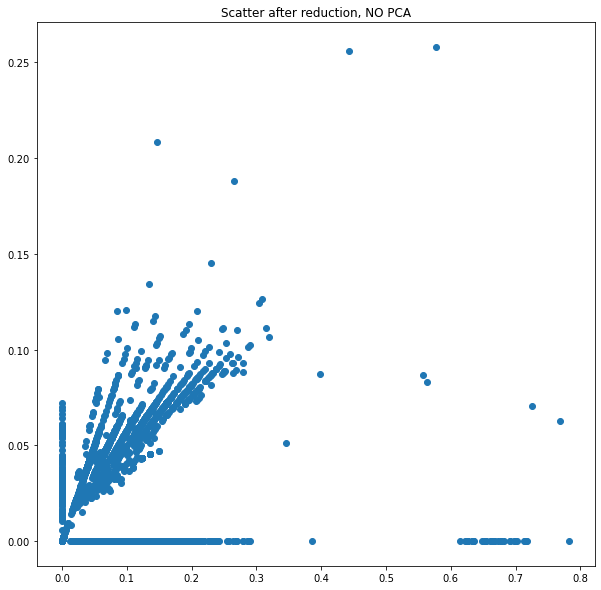

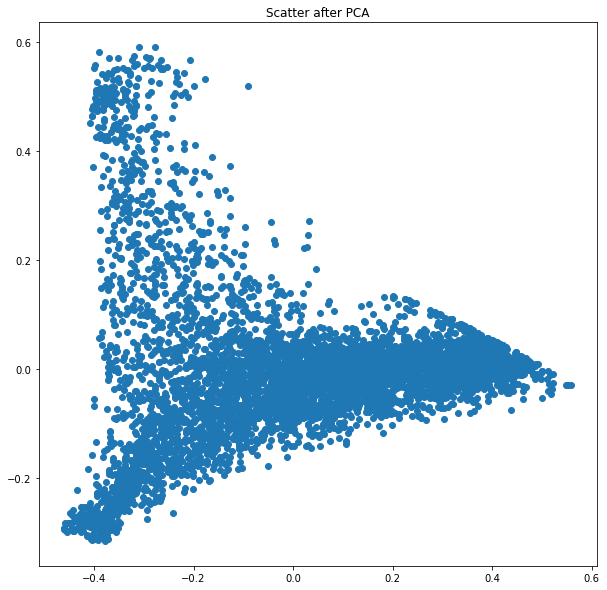

In [121]:
############################################
#### Reduce fingerprints to a 2D matrix ####
############################################


#change shape of fingerprints (3D matrix to 2D matrix)
print('shape of fingerprints',fingerprints.shape)
X = fingerprints.reshape((fingerprints.shape[0], fingerprints.shape[1]**2))

print('shape after reshape',X.shape)

### plot ###
#plot only plots the first 2 parts (x and y)
fig, ax = plt.subplots(1, figsize=(10,10)) #make plot

ax.scatter(X[:, 0], X[:, 1]) #plot points, X[:,0] is the 0 of each datapoint in X
ax.set_title('Scatter after reduction, NO PCA')
###


###############################################
## decomp with PCA on 2D matrix fingerprints ##
###############################################

#pca on data X
pca = decomposition.PCA(n_components=ncom) #get the pca function
pca.fit(X) #use pca on data X




X = pca.transform(X) #use pca to transform data X

print('shape after pca',X.shape)

### plot ###
#plot only plots the first 2 parts (x and y) of ncom
fig, ax = plt.subplots(1, figsize=(10,10)) #make plot

ax.scatter(X[:, 0], X[:, 1]) #plot points, X[:,0] is the 0 of each datapoint in X
ax.set_title('Scatter after PCA')
###

3D scatter plot

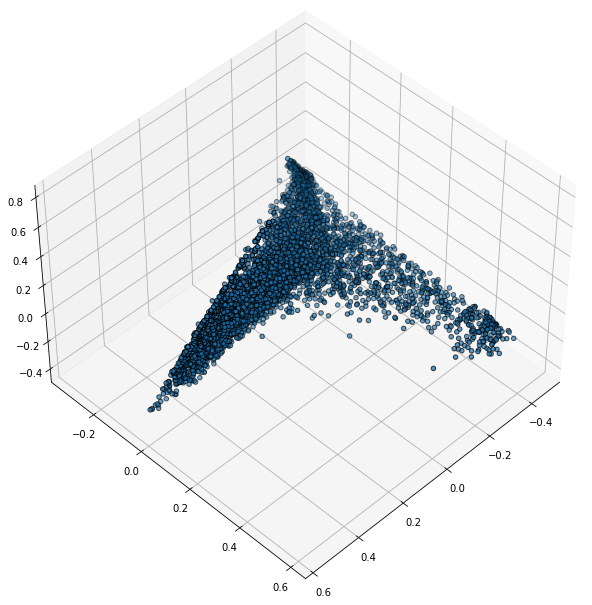

In [122]:
#plot only plots the first 3 parts (x, y, and z) of ncom

fig = plt.figure(1, figsize=(10, 8)) #create figure
plt.clf() #clear the figure

ax = fig.add_subplot(111, projection="3d", elev=45, azim=45) #create 3d subplot, elev and azim change view perspective
ax.set_position([0, 0, 0.95, 1]) #position the subplot


plt.cla() #clear the axes
ax.scatter(X[:, 0], X[:, 1], X[:, 2], edgecolor="k")

## Silhouette Score and SSE

Testing the Silhouette Score of groups across a volcano

Silhouette sccore ranges form -1 to 1. Negative values may indicate incorrect grouping. Close to 0 means the groups are the same. Close to 1 means very well grouped

Silhouette Score will be low with higher ncom.

adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

---

aslo testing the SSE (Sum of Squared Errors) of groups across a volcano

y_true is the cluster centroids

y_pred is the data points

In [123]:
#kmeans clustering w/o loop
# X = fingerprints.reshape((fingerprints.shape[0], fingerprints.shape[1]**2))
n_clusters = 3
clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
cluster_labels = clusterer.fit_predict(X)

For n_clusters = 2 The average silhouette_score is : 0.25138302833645143
for kn = 2, MSE = 0.004996783538113293, SSE = 13.191508540619093
---
For n_clusters = 3 The average silhouette_score is : 0.24567451164157628
for kn = 3, MSE = 0.004852763759846416, SSE = 11.709718952509402
---
For n_clusters = 4 The average silhouette_score is : 0.21581641967022053
for kn = 4, MSE = 0.004764515878004919, SSE = 4.693048139834845
---
For n_clusters = 5 The average silhouette_score is : 0.1961222178680994
for kn = 5, MSE = 0.004094451011147268, SSE = 7.935046059603405
---
For n_clusters = 6 The average silhouette_score is : 0.1662579093842566
for kn = 6, MSE = 0.003438331836658161, SSE = 2.963842043199335
---


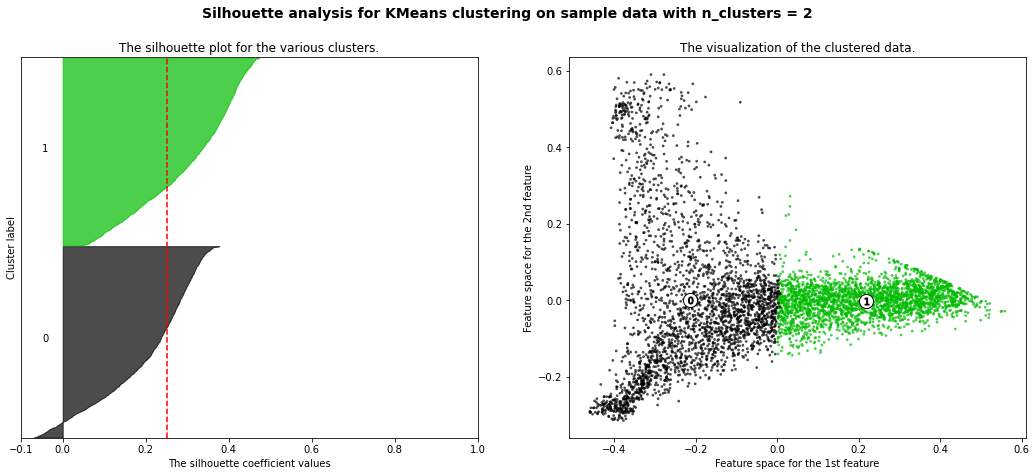

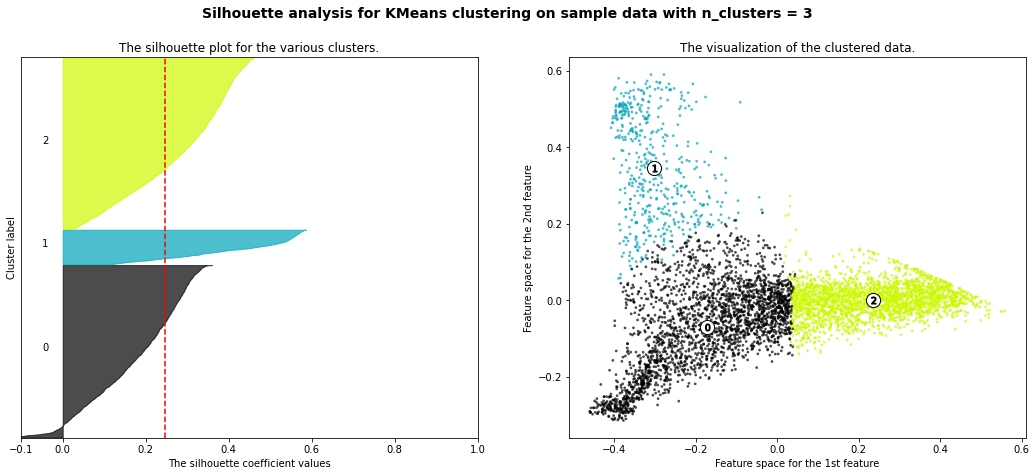

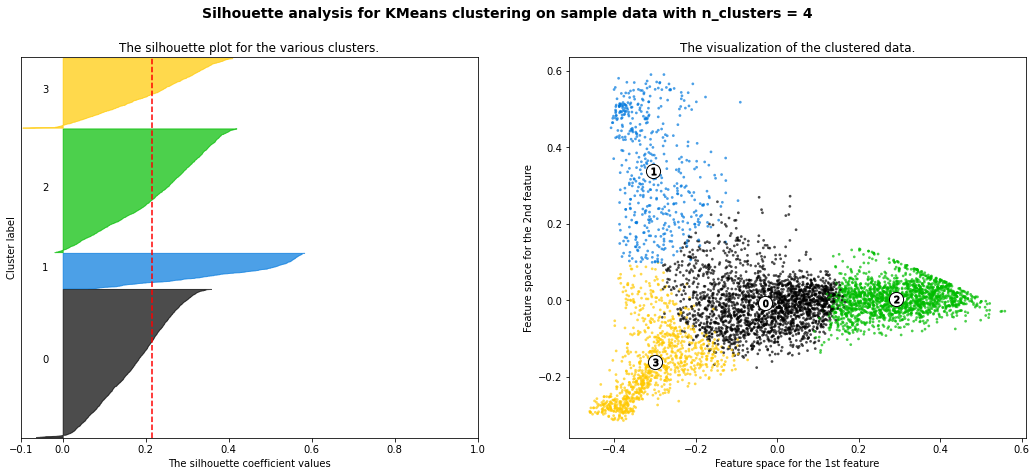

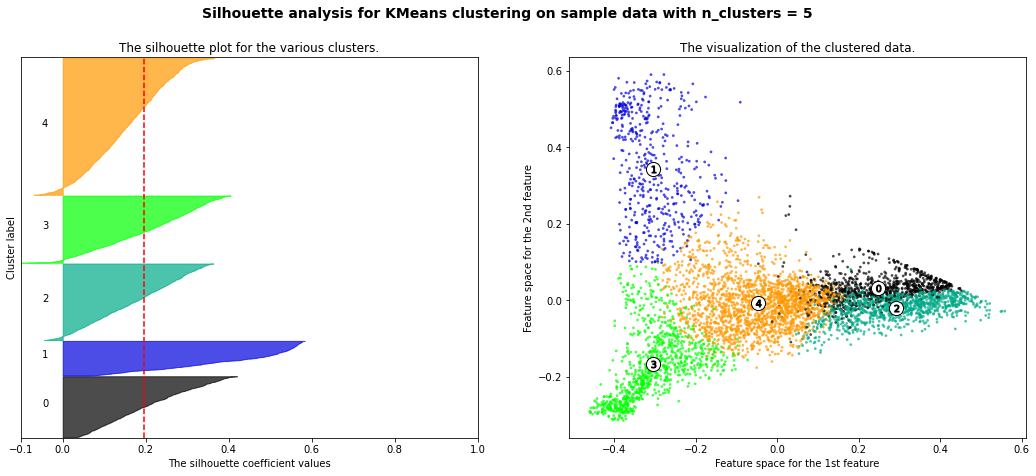

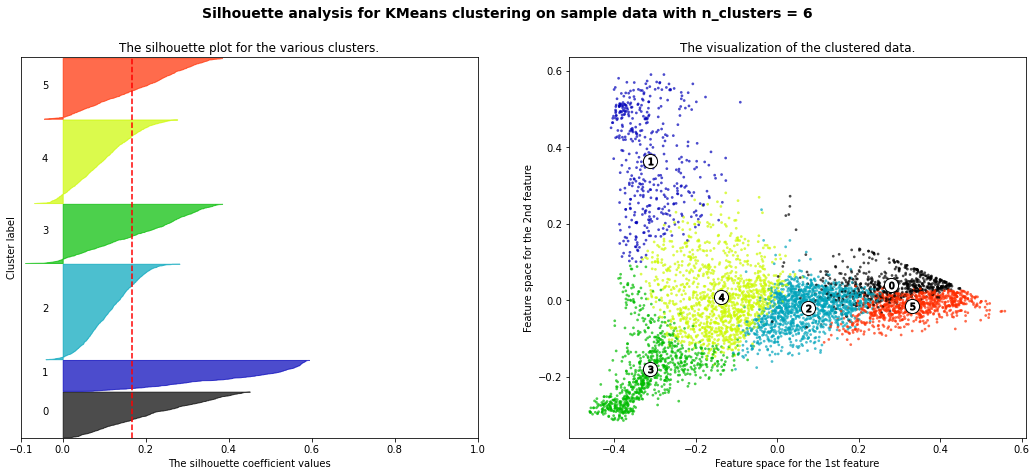

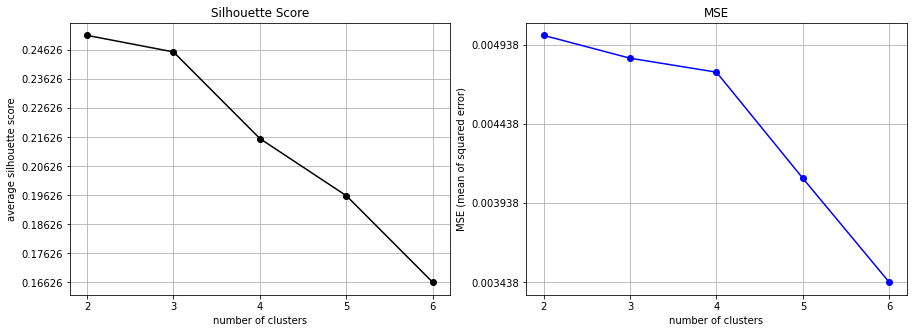

In [124]:
#loop through different number of clusters' silhouette scores
range_n_clusters = [2, 3, 4, 5, 6]

avg_sil = [] #list of average silhouette scores
mse_list = [] #list of SSE
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    avg_sil.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    
    ####################################################################################
    ######                                  SSE                                   ######
    ####################################################################################
    
    #make dataframe to organize kmeans labels
    tdf = pd.DataFrame({"template_name":template_name,"waveform":list(waveforms),"kmeans":list(cluster_labels)})

    centroids  = clusterer.cluster_centers_ #get the centroid locations

    y_pred = [] #will be a list of arrays
    y_true = [] #will be a list of the centroid repeating to get len(y_true) == len(y_pred)

    inx_list = tdf[tdf['kmeans']==n_clusters-1].index.tolist() #get index of cluster_labels

    for inx in inx_list: #for each index
        y_pred.append(X[inx]) #save that from the data
        y_true.append(centroids[n_clusters-1]) #get correct length (same point for the same length as y_pred)

    mse = mean_squared_error(y_true,y_pred) #calculated mean squared error with sklearn

    print(f'for kn = {n_clusters}, MSE = {mse}, SSE = {mse*len(y_pred)}')
    
    mse_list.append(mse)

    ####################################################################################
    
    print('---')
    
plt.show()

fig, (ax, ax1) = plt.subplots(1,2,figsize=(15,5))

ax.plot(range_n_clusters,avg_sil,marker='o',color='black')
ax.set_title('Silhouette Score')
ax.set_ylabel('average silhouette score')
ax.set_xlabel('number of clusters')
ax.set_xticks(np.arange(min(range_n_clusters), max(range_n_clusters)+1, 1))
ax.set_yticks(np.arange((min(avg_sil)), (max(avg_sil)), .01))
ax.grid(True)

ax1.plot(range_n_clusters,mse_list,marker='o',color='blue')
ax1.set_title('MSE')
ax1.set_ylabel('MSE (mean of squared error)')
ax1.set_xlabel('number of clusters')
ax1.set_xticks(np.arange(min(range_n_clusters), max(range_n_clusters)+1, 1))
ax1.set_yticks(np.arange((min(mse_list)), (max(mse_list)), .0005))
ax1.grid(True)




## Looking at waveforms

In [ ]:
tdf.head()

In [ ]:
#show all waveforms in a group
kn = 3 #Kmeans group ID/number
print(f'===== PLOTS FOR KMEANS GROUP {kn} =====')

wave_list = tdf[tdf['kmeans']==kn]['waveform'].values.tolist() #list of waveforms for a Kmeans group

for ww,wave in enumerate(wave_list):
    Trace(wave).plot();
    print(template_name[ww])
#   break

In [ ]:
#print the number of waveforms
for kn in [0,1,2,3,4,5]:
    print(f"kmeans group {kn} has {len(tdf[tdf['kmeans']==kn]['waveform'].values.tolist())} waveforms") #list of waveforms for a Kmeans group

In [ ]:
#plotting for stacked spectrograms

#each subplot will show the waveforms for a kmeans group
#within each subplot, the waveforms for one REDPy cluster will be shown as one color, 
#other clusters will have their own colors
#the subplots will also be divided into two or three columns to avoid having very long plots

from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker


ax_list = np.arange(0,n_clusters,1) #list of groups, can do np.arange(0,n_clusters,1)

ncols = 6 #number of columns, stays consistent
nrows = math.ceil(len(ax_list)/ncols) #determines number of rows needed by rounding up to nearest whole number

fig, ax0 = plt.subplots(figsize=(ncols*4,nrows*100))
gs = GridSpec(nrows, ncols, figure=fig) #make GridSpec for formatting subplots, based on ncols and nrows
plt.tight_layout() #tight layout for looking nice


for aa,ax_n in enumerate(ax_list):#for each subplot
#     print(f'----{ax_n}----')
    ax = fig.add_subplot(gs[math.floor(aa/ncols):math.floor(aa/ncols)+1,aa - math.floor(aa/ncols)*6:aa - math.floor(aa/ncols)*ncols +1]) #add subplot
    ax.set_title(f'Group Index {ax_n}') #label
    
    
    wave_list = [Trace(i) for i in tdf[tdf['kmeans']==ax_n]['waveform'].values.tolist()] #list of waveforms for a Kmeans group
    print(len(wave_list))
    
    yscale = 2 #how far to space waveforms frome eachother
    for ww, wave in enumerate(wave_list):
        ax.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color='black',linewidth=.5)
        
    x = np.arange(0,len(wave.data),1) #get np array of x points
    xscale = 40 #samling rate in hz
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/xscale)) #set ticks in seconds instead of samples, 40 is sampling rate
    ax.xaxis.set_major_formatter(ticks) #set ticks
    ax.set_xlabel('Time (s)')
    
    y = np.arange(1,len(wave_list),1) #get np array of y points
    #yscale defined above
    ticks = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/yscale)) #set ticks in seconds instead of samples, 40 is sampling rate
    ax.yaxis.set_major_formatter(ticks) #set ticks
    ax.set_ylim(1,(len(wave_list)*yscale)+(.5*yscale))
    ax.set_ylabel('Number of Waveforms')
    
fig.delaxes(ax0) #remove unused ax